In [77]:
import numpy as np
import json
from tqdm.notebook import trange, tqdm
import torch
import pickle as pkl
import pandas as pd
import seaborn as sns

In [14]:
from classes import CLASSES, GENERIC_PROMPT_COLLECTIONS
import torch.nn as nn
from clip import clip
import os
import torch


# Initialize CLIP models 
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype
        self.token_embedding = clip_model.token_embedding

    def forward(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

def load_clip_to_cpu(visual_backbone):
    backbone_name = visual_backbone
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url, os.path.expanduser("~/.cache/clip"))

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())

    return model

clip_model = load_clip_to_cpu("RN50")

visual_model = torch.nn.DataParallel(clip_model.visual).cuda()

text_model = TextEncoder(clip_model)
text_model = torch.nn.DataParallel(text_model).cuda()

Load Test Data

In [15]:
label_cats = json.load(open("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/label_classification.json"))

from data_loader import dataloaders as dataloader
d = dataloader.load_data(
    data_root="../datasets/ImageNet/",
    dataset="ImageNet_LT",
    phase="test",
    batch_size=128,
#     batch_size=1,
    sampler_dic=None,
    num_workers=12,
    type="random_prompts",
    prompt_set="ImageNet",
)
data_test = d[0]

from classes import CLASSES, CUSTOM_TEMPLATES, GENERIC_PROMPT_COLLECTIONS
from tqdm.notebook import trange, tqdm

test_images, test_texts = [], []
test_labels = []

with torch.no_grad():
    for im, label, _, path in tqdm(data_test):
        x = visual_model(im.half()).float()
        x = x / x.norm(dim=-1, keepdim=True)
        test_images.append(x)
        test_labels.append(label)
        
        test_texts
        
test_images = torch.cat(test_images, dim=0)
test_labels = torch.cat(test_labels, dim=0)

Loading data from /nethome/bdevnani3/flash1/long_tail_lang/data/ImageNet_LT/ImageNet_LT_test.txt
Use data transformation: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)
***********************DATASET: test random_prompts
test 50000
No sampler.
Shuffle is True.


  0%|          | 0/391 [00:00<?, ?it/s]

In [16]:
torch.save(test_images, "clip_embedded_images_test.pt")
torch.save(test_labels, "clip_embedded_labels_test.pt")

In [17]:
many_test_images, med_test_images, few_test_images = [], [], []
many_test_labels, med_test_labels, few_test_labels = [], [], []
many_test_inds, med_test_inds, few_test_inds = [], [], []

for i,l in tqdm(zip(test_images, test_labels)):
    
    if l.item() in label_cats["many"]:
        many_test_images.append(i)
        many_test_labels.append(l.item())
        many_test_inds.append(i)
    elif l.item() in label_cats["med"]:
        med_test_images.append(i)
        med_test_labels.append(l.item())
        med_test_inds.append(i)
    elif l.item() in label_cats["few"]:
        few_test_images.append(i)
        few_test_labels.append(l.item())
        few_test_inds.append(i)
        
many_test_images = torch.stack(many_test_images,dim=1)
med_test_images = torch.stack(med_test_images,dim=1)
few_test_images = torch.stack(few_test_images,dim=1)
many_test_labels = torch.tensor(many_test_labels)
med_test_labels = torch.tensor(med_test_labels)
few_test_labels = torch.tensor(few_test_labels)

print(many_test_images.shape, many_test_labels.shape)
print(med_test_images.shape, med_test_labels.shape)
print(few_test_images.shape, few_test_labels.shape)

0it [00:00, ?it/s]

torch.Size([1024, 19250]) torch.Size([19250])
torch.Size([1024, 23450]) torch.Size([23450])
torch.Size([1024, 7300]) torch.Size([7300])


In [54]:
import pandas as pd
df_all = pd.DataFrame()
freqs = json.load(open("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/class_frequencies.json"))
df_all["class_names"] = [CLASSES[x] for x in range(1000)]
df_all["class_counts"] = [freqs[str(x)] for x in range(1000)]

Linear Probe

In [55]:
model_path = "/nethome/bdevnani3/flash1/long_tail_lang/results_sklearn/config_image_linear_probe_0/12-Sep-2022-20-47-57/final_model.sav"
model = pkl.load(open(model_path, 'rb'))
predictions = model.predict(test_images.cpu())
true_labels = test_labels.cpu()

In [56]:
class_wise_acc = np.zeros(1000)
for i in range(len(predictions)):
    if predictions[i] == true_labels[i]:
        class_wise_acc[true_labels[i].item()] +=1
overall_acc = np.mean(class_wise_acc/50)*100
overall_acc


56.147999999999996

In [57]:
df_all["linear_probe"] = class_wise_acc

Convex Comb

In [58]:
model_path = "/nethome/bdevnani3/flash1/long_tail_lang/results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav"
model = pkl.load(open(model_path, 'rb'))
predictions = model.predict(test_images.cpu())
true_labels = test_labels.cpu()
class_wise_acc = np.zeros(1000)
for i in range(len(predictions)):
    if predictions[i] == true_labels[i]:
        class_wise_acc[true_labels[i].item()] +=1
overall_acc = np.mean(class_wise_acc/50)*100
overall_acc

62.194

In [59]:
df_all["convex_comb"] = class_wise_acc
df_all

,class_names,class_counts,linear_probe,convex_comb
0,tench,50,46.0,48.0
1,goldfish,250,44.0,46.0
2,great white shark,516,44.0,31.0
3,tiger shark,352,34.0,32.0
4,hammerhead shark,143,35.0,43.0
5,electric ray,92,26.0,32.0
6,stingray,47,16.0,21.0
7,rooster,45,19.0,36.0
8,hen,150,37.0,33.0
9,ostrich,50,40.0,45.0


In [60]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
df_all

,class_names,class_counts,linear_probe,convex_comb
0,tench,50,46.0,48.0
1,goldfish,250,44.0,46.0
2,great white shark,516,44.0,31.0
3,tiger shark,352,34.0,32.0
4,hammerhead shark,143,35.0,43.0
5,electric ray,92,26.0,32.0
6,stingray,47,16.0,21.0
7,rooster,45,19.0,36.0
8,hen,150,37.0,33.0
9,ostrich,50,40.0,45.0


Post projection

In [61]:
model_path = "/nethome/bdevnani3/flash1/long_tail_lang/results_sklearn/config_text_proj_4/13-Sep-2022-15-57-46/final_model.sav"
model = pkl.load(open(model_path, 'rb'))
predictions = model.predict(test_images.cpu())
true_labels = test_labels.cpu()
class_wise_acc = np.zeros(1000)
for i in range(len(predictions)):
    if predictions[i] == true_labels[i]:
        class_wise_acc[true_labels[i].item()] +=1
overall_acc = np.mean(class_wise_acc/50)*100
overall_acc

60.594

In [62]:
df_all["text_proj"] = class_wise_acc
df_all

,class_names,class_counts,linear_probe,convex_comb,text_proj
0,tench,50,46.0,48.0,48.0
1,goldfish,250,44.0,46.0,45.0
2,great white shark,516,44.0,31.0,33.0
3,tiger shark,352,34.0,32.0,38.0
4,hammerhead shark,143,35.0,43.0,42.0
5,electric ray,92,26.0,32.0,31.0
6,stingray,47,16.0,21.0,13.0
7,rooster,45,19.0,36.0,36.0
8,hen,150,37.0,33.0,40.0
9,ostrich,50,40.0,45.0,40.0


Similarity between image and text

In [63]:
image_embeddings = torch.load("clip_embedded_images.pt").cpu()
text_embeddings = torch.load("clip_embedded_texts.pt").cpu()
labels = torch.load("clip_embedded_image_labels.pt").cpu()

In [69]:
from scipy import spatial

dot = []
cossim = []
for i in tqdm(torch.unique(labels).tolist()):
    cls_idx = np.where(labels == i)
    cls_image_embeddings = image_embeddings[cls_idx].cpu().numpy()
    avg_image_emb = np.mean(cls_image_embeddings, axis= 0)
    cls_text_embeddings = text_embeddings[cls_idx].cpu().numpy()
    avg_text_emb = np.mean(cls_text_embeddings, axis= 0)
    d = avg_image_emb@avg_text_emb
    dot.append(d)
    c = 1 - spatial.distance.cosine(avg_image_emb, avg_text_emb)
    cossim.append(c)
    
df_all["im_text_dot"] = dot
df_all["im_text_cossim"] = cossim

  0%|          | 0/1000 [00:00<?, ?it/s]

In [98]:
df_all["relative_diff"] = (df_all["convex_comb"] - df_all["linear_probe"])*.50
# df_all = df_all.sort_values("relative_diff")
print(df_all.sort_values("relative_diff").index[-20:].tolist())

[840, 317, 996, 993, 997, 285, 513, 274, 225, 223, 849, 307, 222, 376, 162, 40, 878, 301, 82, 992]


In [99]:
print(df_all.sort_values("relative_diff")["relative_diff"][-20:].tolist())

[9.5, 9.5, 9.5, 9.5, 9.5, 10.0, 10.0, 10.5, 10.5, 11.0, 11.0, 11.5, 11.5, 12.0, 12.5, 13.0, 14.5, 15.5, 19.0, 19.5]


In [106]:
df_all.sort_values("relative_diff")

,class_names,class_counts,linear_probe,convex_comb,text_proj,im_text_dot,im_text_cossim,relative_diff,im_dot,dot_ratio,im_text_edist
947,mushroom,284,45.0,13.0,26.0,0.222874,0.289773,-16.0,0.715753,3.211476,1.047137
46,European green lizard,346,42.0,15.0,19.0,0.245600,0.305425,-13.5,0.765740,3.117834,1.057815
52,worm snake,189,40.0,14.0,29.0,0.236063,0.298550,-13.0,0.721264,3.055389,1.056387
235,German Shepherd Dog,281,38.0,14.0,32.0,0.218090,0.291264,-12.0,0.694149,3.182863,1.032306
257,Great Pyrenees dog,282,36.0,14.0,21.0,0.230877,0.301692,-11.0,0.688489,2.982055,1.037960
587,hammer,278,32.0,12.0,20.0,0.195928,0.275768,-10.0,0.607561,3.100932,1.023008
828,strainer,229,30.0,10.0,22.0,0.213459,0.298468,-10.0,0.591400,2.770557,1.014572
119,rock crab,240,36.0,18.0,27.0,0.237607,0.307838,-9.0,0.714076,3.005285,1.035942
725,drink pitcher,454,39.0,21.0,20.0,0.213089,0.289746,-9.0,0.635925,2.984311,1.029691
824,scarf,189,32.0,15.0,32.0,0.201528,0.281308,-8.5,0.606949,3.011733,1.024438


<AxesSubplot:xlabel='relative_diff', ylabel='im_text_dot'>

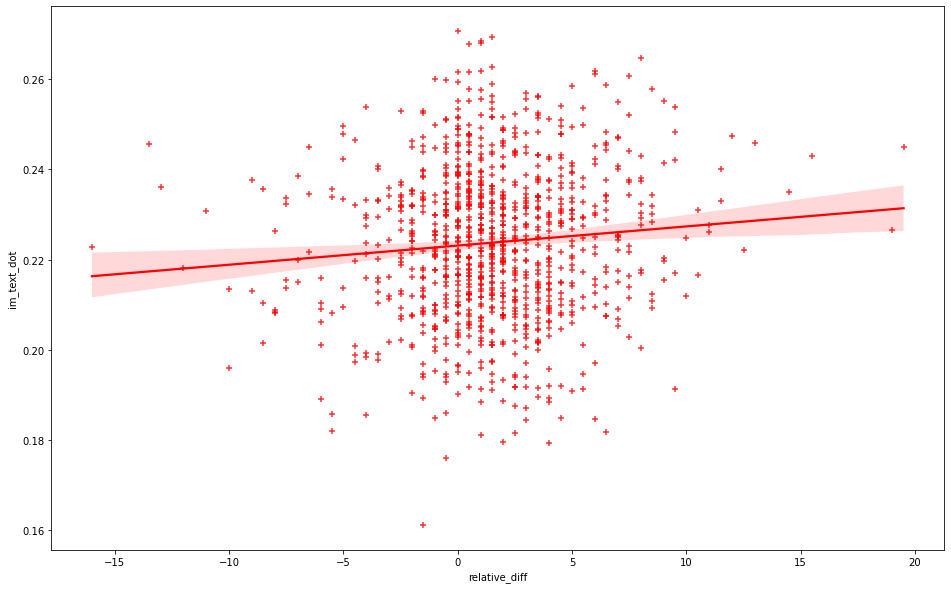

In [100]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
sns.regplot(
    x="relative_diff", y="im_text_dot",
    data=df_all,
    color="r",
    label="image_embedding",
    marker="+"
)

<AxesSubplot:xlabel='class_counts', ylabel='relative_diff'>

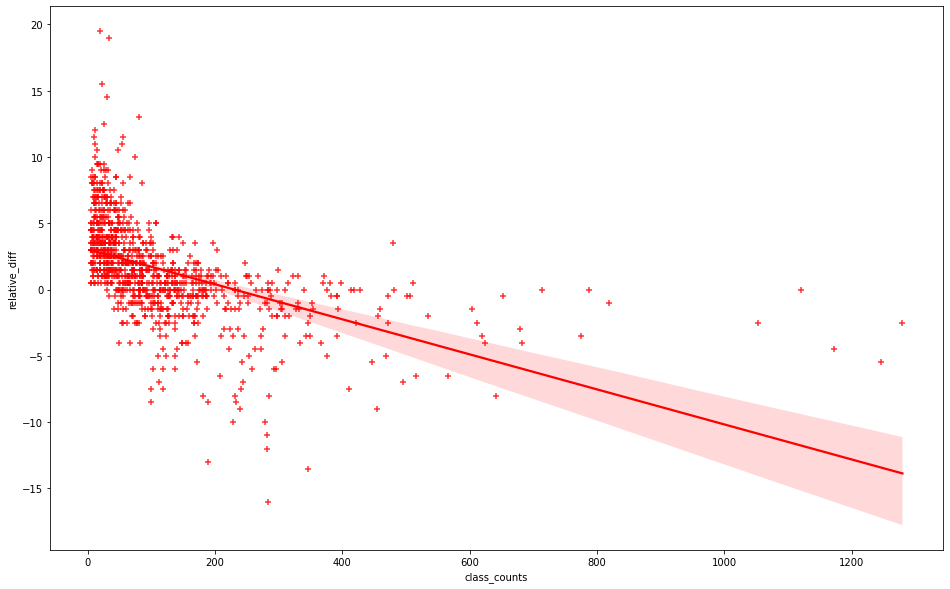

In [102]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
sns.regplot(
    x="class_counts", y="relative_diff",
    data=df_all,
    color="r",
    label="image_embedding",
    marker="+"
)

In [104]:
from scipy import spatial

dist = []
for i in tqdm(torch.unique(labels).tolist()):
    cls_idx = np.where(labels == i)
    cls_image_embeddings = image_embeddings[cls_idx].cpu().numpy()
    avg_image_emb = np.mean(cls_image_embeddings, axis= 0)
    cls_text_embeddings = text_embeddings[cls_idx].cpu().numpy()
    avg_text_emb = np.mean(cls_text_embeddings, axis= 0)
    d = np.linalg.norm(avg_image_emb-avg_text_emb)
    dist.append(d)
    
df_all["im_text_edist"] = dist

  0%|          | 0/1000 [00:00<?, ?it/s]

<AxesSubplot:xlabel='im_text_edist', ylabel='relative_diff'>

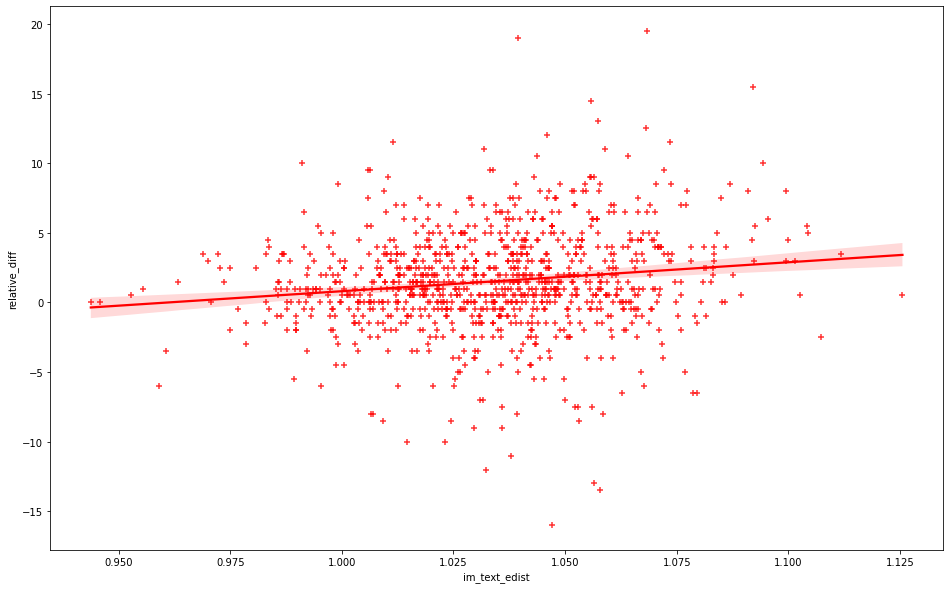

In [105]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
sns.regplot(
    x="im_text_edist", y="relative_diff",
    data=df_all,
    color="r",
    label="image_embedding",
    marker="+"
)